In [1]:
suppressPackageStartupMessages({
  library(dplyr)
  library(pagoda2)
  library(ggplot2)
  library(cowplot)
  library(magrittr)
  library(dataorganizer)
  library(readr)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

ℹ Loading cellAdmixNotebooks


In [2]:
# load the spatial data
data <- prepare_brain_tx_and_meta()
cell_annot <- data[[1]]
df <- data[[2]]

# convert it to counts form
spatial_seurat <- get_counts_meta_seurat(df, normalize=TRUE)

Normalizing layer: counts



In [3]:
# reload the scRNA data
sc_seurat_clean <- prepare_brain_scrna(short_idents=FALSE)

In [4]:
# get DE genes from scRNA data
sc_pgda <- sc_seurat_clean[['RNA']]$counts %>% basicP2proc(
  n.cores=1, min.cells.per.gene=0, min.transcripts.per.cell = 10,
  n.odgenes=2e3, get.largevis=FALSE, make.geneknn=FALSE, get.tsne = FALSE
)

29760 cells, 27998 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

2488 overdispersed genes ... 2488

persisting ... 

done.

running PCA using 2000 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


In [5]:
ct_annot <- sc_seurat_clean@meta.data$Cell_class
names(ct_annot) <- rownames(sc_seurat_clean@meta.data)
de_out_mark <- sc_pgda$getDifferentialGenes(
  verbose=TRUE, groups=ct_annot, z.threshold=0,
  upregulated.only=TRUE, append.auc=TRUE
)

running differential expression with 9 clusters ... 

adjusting p-values ... 

done.


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 4.2 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 4.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 5.2 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 5.7 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 4.5 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 5.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.9 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 4.1 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 4.3 GiB”


In [9]:
# put into a table
de_genes <- lapply(1:length(de_out_mark), \(i){
  ct_nm <- names(de_out_mark)[i]
  x <- de_out_mark[[i]]

  # add pvalues
  x$padj <- 2*pnorm(abs(x$Z), mean = 0, sd = 1, lower.tail = FALSE)

  x$cell_type <- ct_nm
  rownames(x) <- NULL
  return(x)
})

de_genes_full1 <- do.call("rbind.data.frame",de_genes)

# subset to same genes in spatial data
de_genes_full1 <- de_genes_full1[de_genes_full1$Gene %in% rownames(spatial_seurat),]

In [10]:
ct_list <- select_markers_brain(de_genes_full1,sc_seurat_clean)

In [11]:
# extract markers to plot
markers_plot <- lapply(c('Microglia','Endothelial','Mature oligodendrocyte'),function(ct) {
  marker_df_sub <- ct_list[[ct]]
  if (length(marker_df_sub$Gene) > 5) {
    return(marker_df_sub$Gene[1:5])
  } else {
    return(marker_df_sub$Gene)
  }
})
markers_plot <- unique(unlist(markers_plot))
markers_plot <- rev(markers_plot)
markers_plot


[1] "Ndrg1"   "Opalin"  "Lpar1"   "Gjc3"    "Ermn"    "Fn1"     "Slco1a4"
[8] "Slc15a3" "Selplg"

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


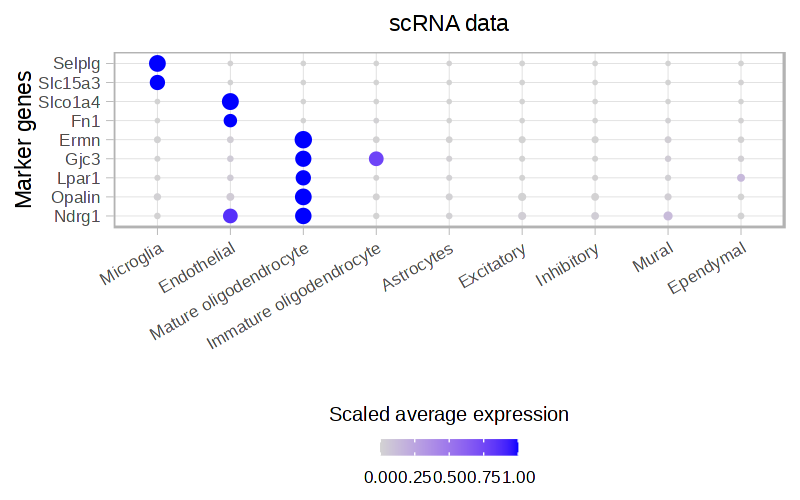

In [14]:
options(repr.plot.width = 4, repr.plot.height = 2.5, repr.plot.res = 200)

# plot the marker dotplots
Idents(sc_seurat_clean) <- sc_seurat_clean@meta.data$Cell_class %>% factor(levels=c(
  'Microglia','Endothelial','Mature oligodendrocyte', 'Immature oligodendrocyte',
  'Astrocytes','Excitatory','Inhibitory', 'Mural','Ependymal'
))

p <- DotPlot(object = sc_seurat_clean, features = markers_plot, # this gets us mean(expm1(nomalized_dat_gene_g_ct_c)) and puts it in avg.exp
             col.min = 0,col.max = 5)

p$data$avg.exp.scaled <- NA
p_dat_lst <- lapply(markers_plot,function(g) {
  p_dat_sub <- p$data[p$data$features.plot==g,]
  X <- p_dat_sub$avg.exp
  min_val <- min(X)
  max_val <- max(X)
  X_std = (X - min_val) / (max_val - min_val)
  p_dat_sub$avg.exp.scaled <- X_std
  return(p_dat_sub)
})

p_dat_lst2 <- do.call(rbind.data.frame,p_dat_lst)

p$data <- p_dat_lst2

p$layers[[1]] <- NULL

p_sc <- p +
  geom_point(mapping = aes_string(size = 'pct.exp', color = 'avg.exp.scaled')) + # change to avg.exp.log or avg.exp.log.scaled or avg.exp.scaled
  coord_flip() +
  xlab('Marker genes') +
  ylab('') +
  ggtitle('scRNA data') +
  theme_light(base_line_size = gg_line_thickness) +
  scale_radius(range = c(0,2)) +
  p_theme +
  theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1),
        legend.key.size = unit(6, 'pt'),
        legend.key.height = unit(6, 'pt'),
        legend.key.width = unit(10, 'pt'),
        legend.title=element_text(size=7),
        legend.text=element_text(size=6),
        legend.position="bottom",
        legend.box="vertical", legend.margin=margin()) +
  guides(colour = guide_colourbar(title.position="top", title.hjust = 0.5),
         size = 'none') +
  labs(colour="Scaled average expression")

p_sc


Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


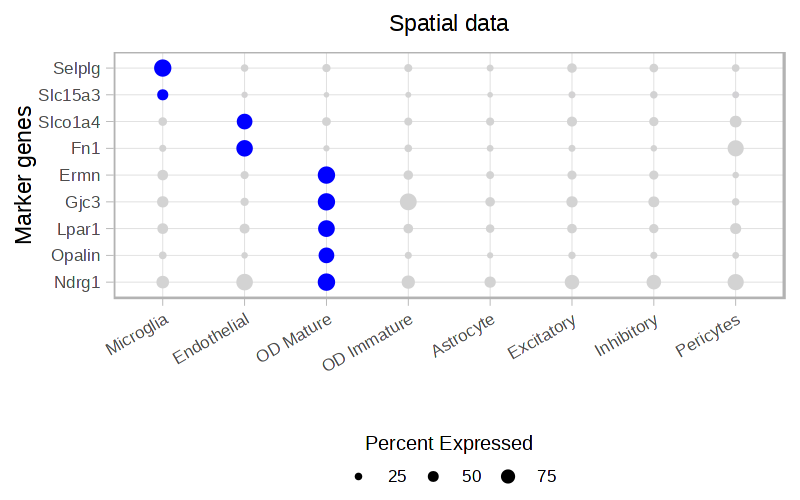

In [15]:
options(repr.plot.width = 4, repr.plot.height = 2.5, repr.plot.res = 200)

# now make the dotplot for the spatial data
Idents(spatial_seurat) <- spatial_seurat@meta.data$cell_type %>% factor(levels=c(
  'Microglia','Endothelial','OD Mature','OD Immature',
  'Astrocyte','Excitatory','Inhibitory', 'Pericytes','Ependymal'
))

spatial_seurat[['RNA']]$data <- spatial_seurat[['RNA']]$counts

p <- DotPlot(object = spatial_seurat, features = markers_plot,
             col.min = 0,col.max = 5)

p$data$avg.exp.scaled <- NA
p_dat_lst <- lapply(markers_plot,function(g) {
  p_dat_sub <- p$data[p$data$features.plot==g,]
  X <- p_dat_sub$avg.exp
  min_val <- min(X)
  max_val <- max(X)
  X_std = (X - min_val) / (max_val - min_val)
  p_dat_sub$avg.exp.scaled <- X_std
  return(p_dat_sub)
})

p_dat_lst2 <- do.call(rbind.data.frame,p_dat_lst)

p$data <- p_dat_lst2

p$layers[[1]] <- NULL

p_spat <- p +
  geom_point(mapping = aes_string(size = 'pct.exp', color = 'avg.exp.scaled')) +
  coord_flip() +
  xlab('Marker genes') +
  ylab('') +
  ggtitle('Spatial data') +
  theme_light(base_line_size = gg_line_thickness) +
  scale_radius(range = c(0,2)) +
  p_theme +
  theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1),
        legend.key.size = unit(6, 'pt'),
        legend.key.height = unit(6, 'pt'),
        legend.key.width = unit(10, 'pt'),
        legend.title=element_text(size=7),
        legend.text=element_text(size=6),
        legend.position="bottom",
        legend.box="vertical", legend.margin=margin()) +
  guides(colour = 'none',
         size = guide_legend(title.position="top", title.hjust = 0.5)) +
  labs(size="Percent Expressed")

p_spat



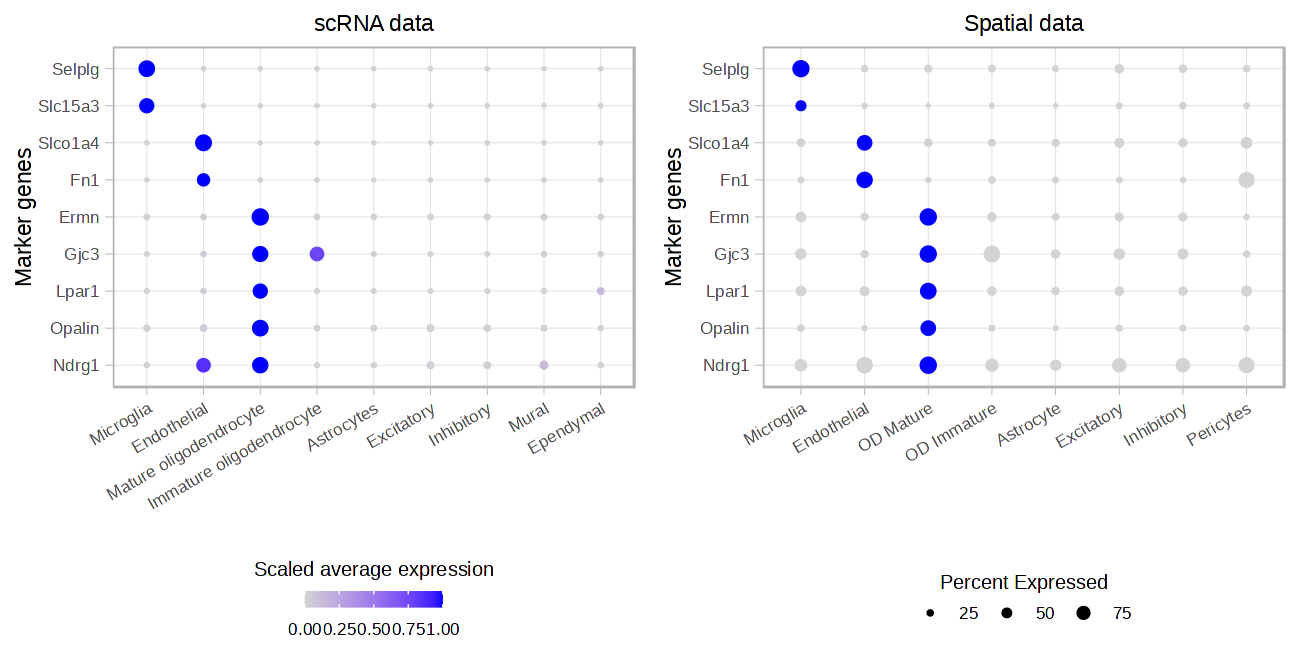

In [18]:
options(repr.plot.width = 6.5, repr.plot.height = 3.25, repr.plot.res = 200)

fig <- cowplot::plot_grid(p_sc,p_spat,nrow=1,rel_widths = c(.5,.5),align = 'hv')
fig

In [19]:
pdf(OutputPath('brain_sc_spatial_marker_dotplots.pdf'), useDingbats=FALSE, width=6.5, height=3.25)
fig
dev.off()

png 
  2

In [20]:
# save the full table of thresholded markers
ct_list_df <- do.call(rbind.data.frame,ct_list)
write.csv(ct_list_df, file=CachePath('brain_markers_sub.csv'))